<a href="https://colab.research.google.com/github/Kartik-git-2004/HOTEL_MANAGEMENT_SYSTEM/blob/main/ML_CASE_STUDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Code for Preprocessing**


---


This code will:
1. Load the dataset.
2. Separate the features and target variable.
3. Standardize the features using StandardScaler.











Split the dataset into a 70-30 train-test split.


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("Brain_Tumor3.csv")

# Separate features (X) and target (y)
X = data.drop(columns=['label'])
y = data['label']

# Standardize the feature data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print to confirm shapes of training and testing sets
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training target set shape:", y_train.shape)
print("Testing target set shape:", y_test.shape)


Training feature set shape: (178, 49)
Testing feature set shape: (77, 49)
Training target set shape: (178,)
Testing target set shape: (77,)





---


# **Code for Principal Component Analysis (PCA)**

---


This code will:

1. Import the PCA module from ***sklearn.decomposition.***

2. Set the number of principal components to 5 (or another specified value).

3. Initialize and apply PCA to reduce the dimensionality of the dataset.

4. Transform both the training and testing sets based on PCA.

5. Print the shapes of the transformed datasets to confirm the dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

# Define number of components for PCA (e.g., 5 components)
n_components = 5

# Initialize PCA with the specified number of components
pca = PCA(n_components=n_components)

# Fit PCA on the training set and transform both training and testing sets
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print to check the shape of the PCA-transformed data
print("PCA-transformed training set shape:", X_train_pca.shape)
print("PCA-transformed testing set shape:", X_test_pca.shape)


PCA-transformed training set shape: (178, 5)
PCA-transformed testing set shape: (77, 5)




---


# ***Code for Training and Evaluating Multiple Models***


---
This code evaluates and compares several machine learning models on both original and PCA-transformed datasets to determine the best model.

Model Setup: A range of models (e.g., Logistic Regression, SVM, Random Forest, XGBoost, etc.) are initialized, including a stacking ensemble model.

Training & Evaluation: Each model is trained on the training data (X_train) and tested on the test data (X_test). Metrics like accuracy, precision, recall, F1-score, and MCC are calculated.

Comparison: The models are evaluated on both original and PCA-transformed datasets. Results are stored in a DataFrame for easy comparison.

Best Model: The model with the highest average performance score across both datasets is selected as the best. This model is then retrained and evaluated.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*SAMME.R.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True),
    "Naïve Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "ANN (MLPClassifier)": MLPClassifier(random_state=42, max_iter=300),
    "BPNN (MLPClassifier)": MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=300),
    "Random Forest with AdaBoost": AdaBoostClassifier(
        estimator=RandomForestClassifier(random_state=42), random_state=42, algorithm='SAMME'
    ),
    "SVM with AdaBoost": AdaBoostClassifier(
        estimator=SVC(probability=True, random_state=42), random_state=42, algorithm='SAMME'
    )
}

# Define stacking ensemble model
stacking_model = StackingClassifier(
    estimators=[("SVM", SVC(probability=True, random_state=42)),
                ("Random Forest", RandomForestClassifier(random_state=42))],
    final_estimator=GaussianNB()
)
models["Stacking Ensemble"] = stacking_model

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }
    return metrics, y_pred


# Initialize dictionaries for ROC curves and AUC scores
roc_curves = {}
auc_scores = {}

# Iterate over Original and PCA datasets
for dataset_type, (X_tr, X_te) in [("Original", (X_train, X_test)), ("PCA", (X_train_pca, X_test_pca))]:
    for model_name, model in models.items():
        model.fit(X_tr, y_train)  # Train the model

        # Check if the model supports predict_proba or decision_function
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_te)[:, 1]  # Probability of positive class
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_te)
        else:
            continue

        # Compute FPR, TPR, and AUC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = auc(fpr, tpr)

        # Store results
        roc_curves[(model_name, dataset_type)] = (fpr, tpr)
        auc_scores[(model_name, dataset_type)] = auc_score


# Evaluate models on both Original and PCA-transformed datasets
results = {"Model": [], "Dataset Type": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": [], "MCC": []}
model_metrics = {}

# Store performance for both datasets
for dataset_type, (X_tr, X_te) in [("Original", (X_train, X_test)), ("PCA", (X_train_pca, X_test_pca))]:
    print(f"\nEvaluating models on {dataset_type} dataset:")
    for model_name, model in models.items():
        metrics, y_pred = train_evaluate_model(model, X_tr, X_te, y_train, y_test)
        results["Model"].append(model_name)
        results["Dataset Type"].append(dataset_type)
        for metric, value in metrics.items():
            results[metric].append(value)

        # Store metrics for comparison later
        model_metrics[(model_name, dataset_type)] = metrics

# Convert results to DataFrame for a comparison table
results_df = pd.DataFrame(results)
print("\nComparison Table of Evaluation Metrics:")
print(results_df)

# Calculate the mean of all metrics (Accuracy, Precision, Recall, F1-Score, MCC) across both datasets
model_scores = []
for model_name in models.keys():
    # Get the metrics for the model on both datasets
    original_metrics = results_df[(results_df['Model'] == model_name) & (results_df['Dataset Type'] == 'Original')]
    pca_metrics = results_df[(results_df['Model'] == model_name) & (results_df['Dataset Type'] == 'PCA')]

    # Calculate the mean score for each model across both datasets
    original_mean_score = original_metrics[["Accuracy", "Precision", "Recall", "F1-Score", "MCC"]].mean(axis=1).values[0]
    pca_mean_score = pca_metrics[["Accuracy", "Precision", "Recall", "F1-Score", "MCC"]].mean(axis=1).values[0]

    # Overall mean score for the model across both datasets
    overall_mean_score = (original_mean_score + pca_mean_score) / 2

    model_scores.append((model_name, overall_mean_score))

# Convert to DataFrame for easier comparison
model_scores_df = pd.DataFrame(model_scores, columns=["Model", "Mean Score"])
model_scores_df = model_scores_df.sort_values(by="Mean Score", ascending=False)

# Display the best model
best_model = model_scores_df.iloc[0]
print(f"\nBest Model across both Original and PCA Datasets: {best_model['Model']} with a Mean Score of {best_model['Mean Score']}")

# Train and evaluate the best model
best_model_name = best_model['Model']
best_model_instance = models[best_model_name]

# Choose the dataset based on the best model's evaluation
best_model_dataset = "Original" if results_df[results_df["Model"] == best_model_name]["Dataset Type"].values[0] == "Original" else "PCA"
X_tr, X_te = (X_train, X_test) if best_model_dataset == "Original" else (X_train_pca, X_test_pca)

# Fit the best model
best_model_instance.fit(X_tr, y_train)
y_pred = best_model_instance.predict(X_te)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 


Evaluating models on Original dataset:


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Evaluating models on PCA dataset:


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Comparison Table of Evaluation Metrics:
                          Model Dataset Type  Accuracy  Precision    Recall  \
0           Logistic Regression     Original  1.000000   1.000000  1.000000   
1           K-Nearest Neighbors     Original  0.987013   1.000000  0.984848   
2        Support Vector Machine     Original  1.000000   1.000000  1.000000   
3                   Naïve Bayes     Original  0.974026   1.000000  0.969697   
4                 Decision Tree     Original  1.000000   1.000000  1.000000   
5                 Random Forest     Original  1.000000   1.000000  1.000000   
6                      AdaBoost     Original  1.000000   1.000000  1.000000   
7                       XGBoost     Original  1.000000   1.000000  1.000000   
8           ANN (MLPClassifier)     Original  0.987013   1.000000  0.984848   
9          BPNN (MLPClassifier)     Original  0.987013   1.000000  0.984848   
10  Random Forest with AdaBoost     Original  1.000000   1.000000  1.000000   
11         



---


**Code for Displaying Evaluation Results in Tabular Format**
---





---

This code will:

1. Define the results data for models evaluated on both the original dataset and PCA-transformed dataset

2. Convert the results into pandas DataFrames for easy viewing and manipulation.

3. Display the results as tables, showing the performance of each model on both the original and PCA datasets.



In [ ]:
import pandas as pd
from IPython.display import display  # For Jupyter Notebooks

# Data for the Original dataset
results_original = {
    "Model": [
        "Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine",
        "Naïve Bayes", "Decision Tree", "Random Forest", "AdaBoost",
        "XGBoost", "ANN (MLPClassifier)", "BPNN (MLPClassifier)",
        "Random Forest with AdaBoost", "SVM with AdaBoost", "Stacking Ensemble"
    ],
    "Dataset Type": ["Original"] * 13,
    "Accuracy": [
        1.0, 0.987012987012987, 1.0, 0.974025974025974, 1.0, 1.0, 1.0,
        1.0, 0.987012987012987, 0.987012987012987, 1.0, 1.0, 1.0
    ],
    "Precision": [
        1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
        1.0, 1.0, 1.0, 1.0, 1.0, 1.0
    ],
    "Recall": [
        1.0, 0.9848484848484849, 1.0, 0.9696969696969697, 1.0, 1.0, 1.0,
        1.0, 0.9848484848484849, 0.9848484848484849, 1.0, 1.0, 1.0
    ],
    "F1-Score": [
        1.0, 0.9923664122137404, 1.0, 0.9846153846153847, 1.0, 1.0, 1.0,
        1.0, 0.9923664122137404, 0.9923664122137404, 1.0, 1.0, 1.0
    ],
    "MCC": [
        1.0, 0.9501461875826149, 1.0, 0.9058216273156766, 1.0, 1.0, 1.0,
        1.0, 0.9501461875826149, 0.9501461875826149, 1.0, 1.0, 1.0
    ]
}

# Data for the PCA dataset
results_pca = {
    "Model": [
        "PCA + Logistic Regression", "PCA + K-Nearest Neighbors", "PCA + Support Vector Machine",
        "PCA + Naïve Bayes", "PCA + Decision Tree", "PCA + Random Forest", "PCA + AdaBoost",
        "PCA + XGBoost", "PCA + ANN (MLPClassifier)", "PCA + BPNN (MLPClassifier)",
        "PCA + Random Forest with AdaBoost", "PCA + SVM with AdaBoost", "PCA + Stacking Ensemble"
    ],
    "Dataset Type": ["PCA"] * 13,
    "Accuracy": [
        0.974025974025974, 0.987012987012987, 1.0, 0.987012987012987, 0.935064935064935, 0.987012987012987,
        0.974025974025974, 0.961038961038961, 1.0, 1.0, 0.974025974025974, 0.8571428571428571, 0.987012987012987
    ],
    "Precision": [
        0.9848484848484849, 1.0, 1.0, 1.0, 0.9841269841269841, 1.0,
        0.9848484848484849, 0.9701492537313433, 1.0, 1.0, 0.9848484848484849, 0.8571428571428571, 1.0
    ],
    "Recall": [
        0.9848484848484849, 0.9848484848484849, 1.0, 0.9848484848484849, 0.9393939393939394, 0.9848484848484849,
        0.9848484848484849, 0.9848484848484849, 1.0, 1.0, 0.9848484848484849, 1.0, 0.9848484848484849
    ],
    "F1-Score": [
        0.9848484848484849, 0.9923664122137404, 1.0, 0.9923664122137404, 0.9612403100775194, 0.9923664122137404,
        0.9848484848484849, 0.9774436090225563, 1.0, 1.0, 0.9848484848484849, 0.9230769230769231, 0.9923664122137404
    ],
    "MCC": [
        0.8939393939393939, 0.9501461875826149, 1.0, 0.9501461875826149, 0.769800358919501, 0.9501461875826149,
        0.8939393939393939, 0.8359163946863781, 1.0, 1.0, 0.8939393939393939, 0.0, 0.9501461875826149
    ]
}

# Convert results to DataFrames
df_original = pd.DataFrame(results_original)
df_pca = pd.DataFrame(results_pca)

# Display tables
print("Table 1: Results on Original Dataset")
display(df_original)  # Use display() for Jupyter notebooks

print("\nTable 2: Results on PCA Dataset")
display(df_pca)  # Use display() for Jupyter notebooks


Table 1: Results on Original Dataset


,Model,Dataset Type,Accuracy,Precision,Recall,F1-Score,MCC
0,Logistic Regression,Original,1.000000,1.0,1.000000,1.000000,1.000000
1,K-Nearest Neighbors,Original,0.987013,1.0,0.984848,0.992366,0.950146
2,Support Vector Machine,Original,1.000000,1.0,1.000000,1.000000,1.000000
3,Naïve Bayes,Original,0.974026,1.0,0.969697,0.984615,0.905822
4,Decision Tree,Original,1.000000,1.0,1.000000,1.000000,1.000000
5,Random Forest,Original,1.000000,1.0,1.000000,1.000000,1.000000
6,AdaBoost,Original,1.000000,1.0,1.000000,1.000000,1.000000
7,XGBoost,Original,1.000000,1.0,1.000000,1.000000,1.000000
8,ANN (MLPClassifier),Original,0.987013,1.0,0.984848,0.992366,0.950146
9,BPNN (MLPClassifier),Original,0.987013,1.0,0.984848,0.992366,0.950146



Table 2: Results on PCA Dataset


,Model,Dataset Type,Accuracy,Precision,Recall,F1-Score,MCC
0,PCA + Logistic Regression,PCA,0.974026,0.984848,0.984848,0.984848,0.893939
1,PCA + K-Nearest Neighbors,PCA,0.987013,1.000000,0.984848,0.992366,0.950146
2,PCA + Support Vector Machine,PCA,1.000000,1.000000,1.000000,1.000000,1.000000
3,PCA + Naïve Bayes,PCA,0.987013,1.000000,0.984848,0.992366,0.950146
4,PCA + Decision Tree,PCA,0.935065,0.984127,0.939394,0.961240,0.769800
5,PCA + Random Forest,PCA,0.987013,1.000000,0.984848,0.992366,0.950146
6,PCA + AdaBoost,PCA,0.974026,0.984848,0.984848,0.984848,0.893939
7,PCA + XGBoost,PCA,0.961039,0.970149,0.984848,0.977444,0.835916
8,PCA + ANN (MLPClassifier),PCA,1.000000,1.000000,1.000000,1.000000,1.000000
9,PCA + BPNN (MLPClassifier),PCA,1.000000,1.000000,1.000000,1.000000,1.000000


# Code for Confusion Matrix and ROC Curves


1. Import Necessary Libraries



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
import seaborn as sns


# 2. **Confusion** Matrix for the Best Model

Top Candidates with PCA: Models with perfect scores (1.0) on the PCA dataset include:

1. Support Vector Machine
2. ANN (MLPClassifier)
3. BPNN (MLPClassifier)



 Since Support Vector Machine (SVM) has perfect scores in both Original and PCA datasets, it’s a strong candidate for the best-performing model due to its high consistency and robustness across different representations of the dataset.




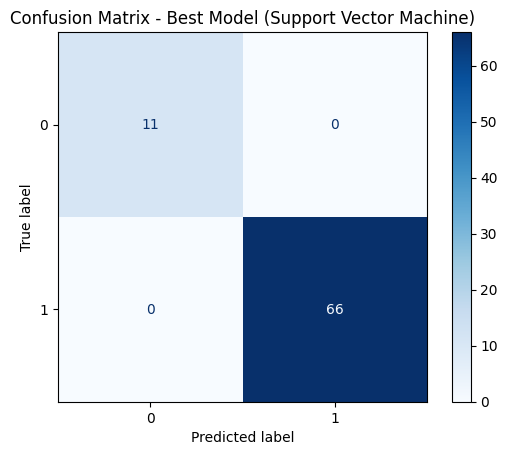

In [ ]:
# Plot confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title(f"Confusion Matrix - Best Model ({best_model_name})")
plt.show()


# 3. ROC Curve Comparison
For ROC curves, let’s compare a few models, like Logistic Regression, Random Forest, and SVM, to visualize which one has the best performance. Here’s how to do it:

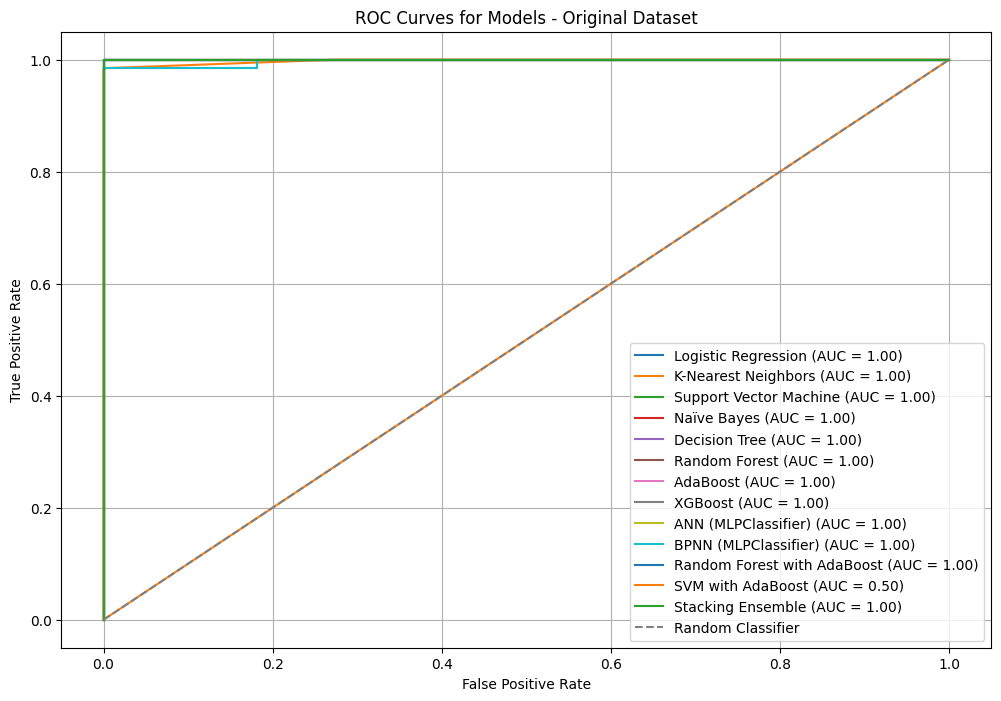

In [ ]:
# Separate ROC Curves for Original Dataset
plt.figure(figsize=(12, 8))
for (model_name, dataset_type), (fpr, tpr) in roc_curves.items():
    if dataset_type == "Original":
        auc_score = auc_scores[(model_name, dataset_type)]
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")
plt.title("ROC Curves for Models - Original Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()




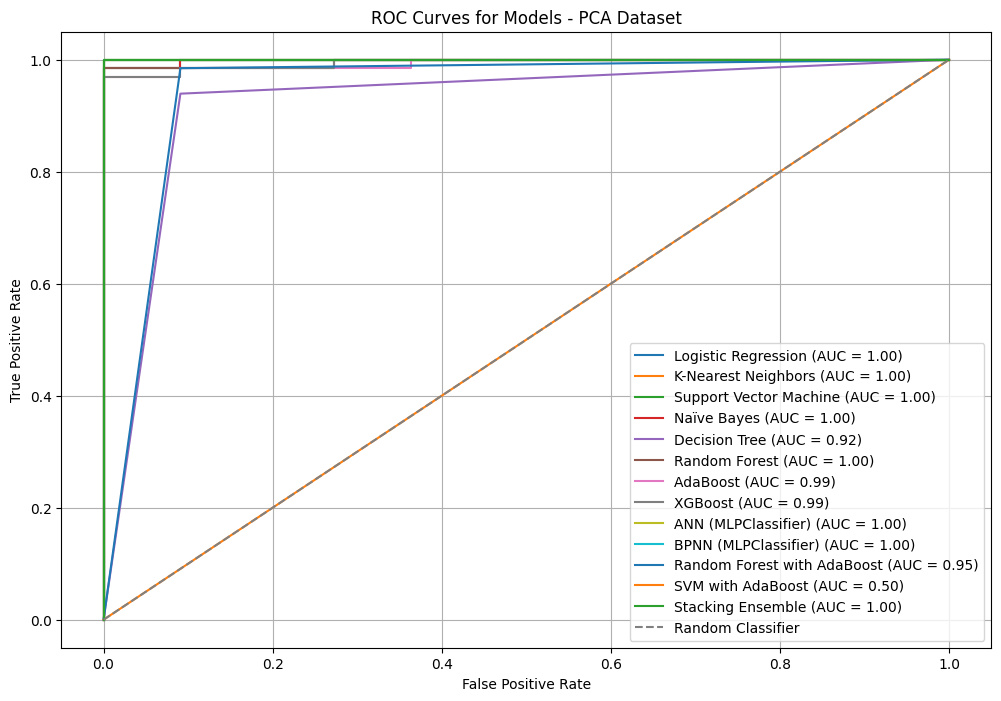

In [ ]:
# Separate ROC Curves for PCA Dataset
plt.figure(figsize=(12, 8))
for (model_name, dataset_type), (fpr, tpr) in roc_curves.items():
    if dataset_type == "PCA":
        auc_score = auc_scores[(model_name, dataset_type)]
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")
plt.title("ROC Curves for Models - PCA Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Accuracy Comparison Bar Chart

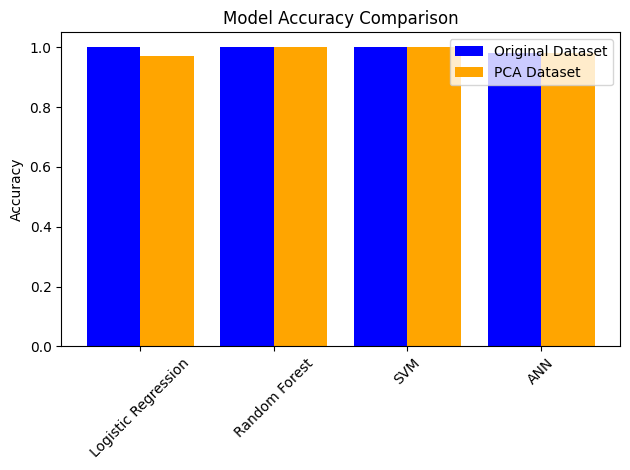

In [ ]:
import matplotlib.pyplot as plt

# Example dat
models = ['Logistic Regression', 'Random Forest', 'SVM', 'ANN']
accuracy_original = [1.0000, 1.0000, 1.0000, 0.98]
accuracy_pca = [0.97, 1.0, 1.0, 0.98]

# Bar chart
x = range(len(models))
plt.bar(x, accuracy_original, width=0.4, label='Original Dataset', color='blue')
plt.bar([p + 0.4 for p in x], accuracy_pca, width=0.4, label='PCA Dataset', color='orange')

plt.xticks([p + 0.2 for p in x], models, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.tight_layout()
plt.show()


Dataset Preview:
   image_index  label   feature_1  feature_2  feature_3  feature_4  \
0            0      0  187.879517   0.000028        0.0 -67.871209   
1            1      0  192.589840   0.000000        0.0 -35.954060   
2            2      0  197.548606   0.000269        0.0 -37.846097   
3            3      0  191.630419   0.000000        0.0 -52.210591   
4            4      0  189.214836   0.000000        0.0 -42.573187   

     feature_5    feature_6   feature_7  feature_8  ...  feature_39  \
0  1683.615165  1751.486373  345.244524   0.173712  ...         0.0   
1  1802.809536  1838.763597  375.358839   0.000001  ...         0.0   
2  1670.718577  1708.564675  355.056411   0.465715  ...         0.0   
3  1674.636061  1726.846652  347.692100   0.067091  ...         0.0   
4  1760.991608  1803.564795  346.934275   0.027236  ...         0.0   

   feature_40  feature_41  feature_42  feature_43  feature_44  feature_45  \
0   -171.9375    167.5625    339.5000   12.108313         

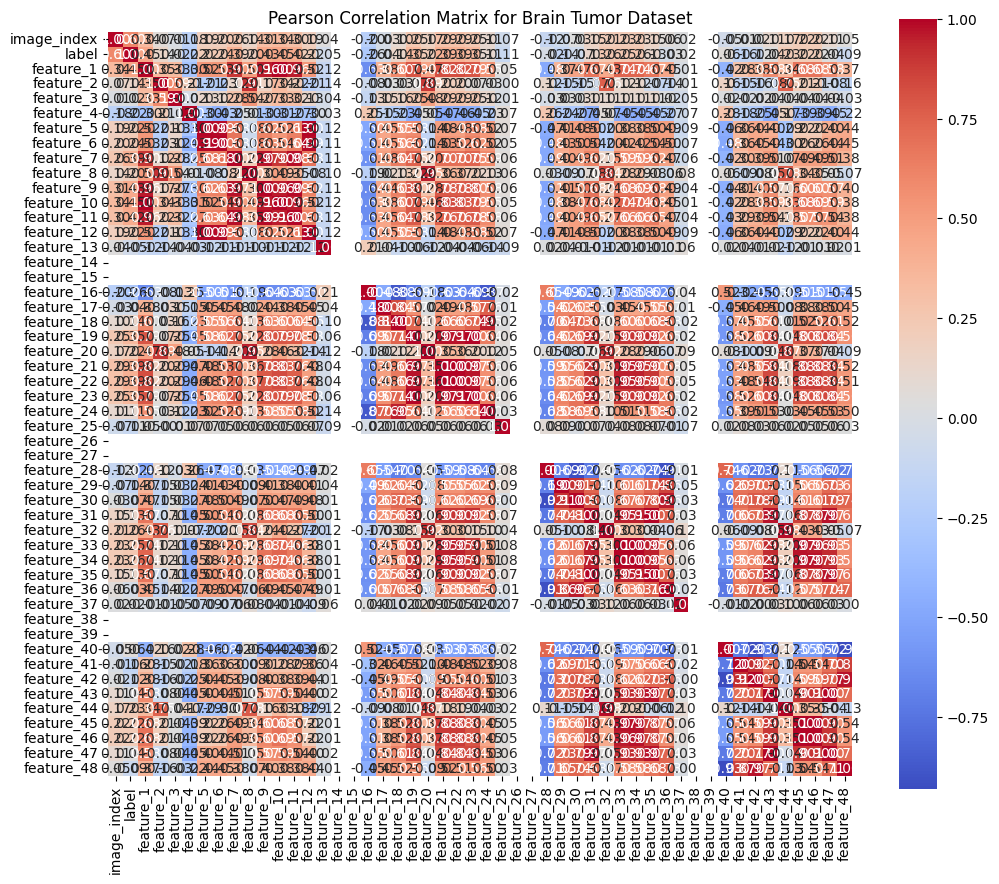

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your brain tumor dataset
df = pd.read_csv('/content/Brain_Tumor3.csv')  # Replace with your actual file path

# Display a preview of the dataset
print("Dataset Preview:")
print(df.head())

# Check for numerical columns (only these can be correlated)
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
print("\nNumerical Columns for Correlation:")
print(numerical_columns)

# Calculate Pearson Correlation Matrix
correlation_matrix = df[numerical_columns].corr(method='pearson').round(2)

# Display the Pearson Correlation Matrix
print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Highlight strong correlations (threshold can be adjusted)
threshold = 0.7
print("\nPerformance of Pearson Correlation:")

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx:  # Exclude self-correlation
            corr_value = correlation_matrix.loc[idx, col]
            if corr_value >= threshold:
                print(f"Strong Positive Correlation: {idx} and {col} -> {corr_value}")
            elif corr_value <= -threshold:
                print(f"Strong Negative Correlation: {idx} and {col} -> {corr_value}")

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson Correlation Matrix for Brain Tumor Dataset")
plt.show()


Dataset Preview:
   image_index  label   feature_1  feature_2  feature_3  feature_4  \
0            0      0  187.879517   0.000028        0.0 -67.871209   
1            1      0  192.589840   0.000000        0.0 -35.954060   
2            2      0  197.548606   0.000269        0.0 -37.846097   
3            3      0  191.630419   0.000000        0.0 -52.210591   
4            4      0  189.214836   0.000000        0.0 -42.573187   

     feature_5    feature_6   feature_7  feature_8  ...  feature_39  \
0  1683.615165  1751.486373  345.244524   0.173712  ...         0.0   
1  1802.809536  1838.763597  375.358839   0.000001  ...         0.0   
2  1670.718577  1708.564675  355.056411   0.465715  ...         0.0   
3  1674.636061  1726.846652  347.692100   0.067091  ...         0.0   
4  1760.991608  1803.564795  346.934275   0.027236  ...         0.0   

   feature_40  feature_41  feature_42  feature_43  feature_44  feature_45  \
0   -171.9375    167.5625    339.5000   12.108313         

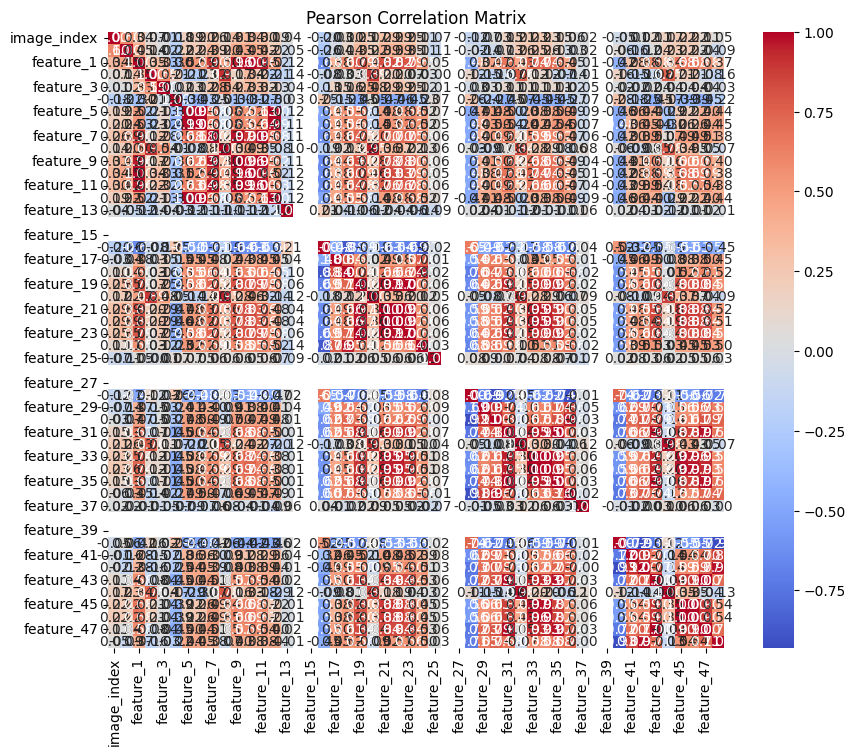


2. t-Test:
Columns Feature1 or Feature2 not found in the dataset.

3. ANOVA:
Columns Feature3 or Category not found in the dataset.

4. Chi-Square Test:
Columns Category1 or Category2 not found in the dataset.


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# Load the brain tumor dataset
df = pd.read_csv('/content/Brain_Tumor3.csv')  # Replace with your file path

# Preview the dataset
print("Dataset Preview:")
print(df.head())

# --- 1. Pearson Correlation ---
print("\n1. Pearson Correlation:")

# Select numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_features.corr(method='pearson').round(2)

# Display Pearson correlation matrix
print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Pearson Correlation Matrix")
plt.show()

# --- 2. t-Test ---
print("\n2. t-Test:")

# Example: Perform t-test between two numerical columns (modify these as needed)
column_1 = 'Feature1'  # Replace with column name
column_2 = 'Feature2'  # Replace with column name

if column_1 in df.columns and column_2 in df.columns:
    t_stat, p_value = ttest_ind(df[column_1], df[column_2], nan_policy='omit')
    print(f"t-Test between {column_1} and {column_2}:")
    print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
else:
    print(f"Columns {column_1} or {column_2} not found in the dataset.")

# --- 3. ANOVA ---
print("\n3. ANOVA:")

# Example: Perform ANOVA for one numerical column across groups in a categorical column
numerical_col = 'Feature3'  # Replace with a numerical column name
categorical_col = 'Category'  # Replace with a categorical column name

if numerical_col in df.columns and categorical_col in df.columns:
    groups = [group[numerical_col].dropna() for _, group in df.groupby(categorical_col)]
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA for {numerical_col} across {categorical_col} groups:")
    print(f"F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
else:
    print(f"Columns {numerical_col} or {categorical_col} not found in the dataset.")

# --- 4. Chi-Square Test ---
print("\n4. Chi-Square Test:")

# Example: Perform Chi-Square test for two categorical columns
cat_col_1 = 'Category1'  # Replace with first categorical column name
cat_col_2 = 'Category2'  # Replace with second categorical column name

if cat_col_1 in df.columns and cat_col_2 in df.columns:
    contingency_table = pd.crosstab(df[cat_col_1], df[cat_col_2])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Test between {cat_col_1} and {cat_col_2}:")
    print(f"Chi2-statistic = {chi2_stat:.4f}, p-value = {p_value:.4f}, degrees of freedom = {dof}")
    print("Expected Frequencies:")
    print(expected)
else:
    print(f"Columns {cat_col_1} or {cat_col_2} not found in the dataset.")
